In [ ]:
import keras.backend as K
import keras
from keras.layers import Input, Lambda, Dense, Conv2D, Flatten
from keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from sklearn.manifold import TSNE
import pandas as pd
from keras import utils as np_util
from keras.utils import to_categorical

# 定义对比损失函数
def contrastive_loss(y_true, y_pred, margin=1):
    square_pred = K.square(y_pred)
    square_margin = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * square_margin)

# 定义输入
input_shape = (28, 28, 1)
input_layer = Input(shape=input_shape)

# 定义模型
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(conv1)
flatten = Flatten()(conv2)
embedding = Dense(128)(flatten)
output_layer = Dense(10, activation='softmax')(embedding)

# 添加对比损失函数
label_input = Input(shape=(1,))
contrastive_output = Lambda(lambda x: K.l2_normalize(x, axis=1))(embedding)
contrastive_loss_layer = Lambda(lambda x: contrastive_loss(x[0], x[1]))([label_input, contrastive_output])

# 定义模型
model = Model(inputs=[input_layer, label_input], outputs=[output_layer, contrastive_loss_layer])
model.compile(optimizer='adam', loss=['categorical_crossentropy', lambda y_true, y_pred: y_pred])

In [174]:
# 加载数据集（可切换）
(x_train_all, y_train_all), (x_test, y_test) = keras.datasets.mnist.load_data()
#(x_train_all,y_train_all),(x_test,y_test) = keras.datasets.fashion_mnist.load_data()


# 将训练集分为训练集和验证集
x_val, x_train = x_train_all[:5000], x_train_all[5000:]
y_val, y_train = y_train_all[:5000], y_train_all[5000:]

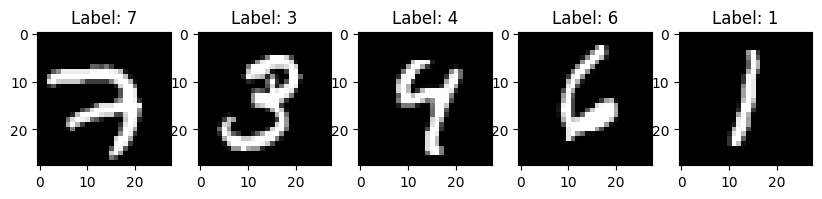

In [175]:
# 输出前五张图片和对应标签
fig, axs = plt.subplots(1, 5, figsize=(10, 5))
for i, ax in enumerate(axs):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title("Label: {}".format(y_train[i]))
plt.show()

In [ ]:
# DataGenerater
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, y, batch_size=32, shuffle=True):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        x_batch = self.x[indexes]
        y_batch = self.y[indexes]
        return [x_batch, y_batch], np.zeros((len(x_batch), 1))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.x))
        if self.shuffle:
            np.random.shuffle(self.indexes)

# 训练模型
batch_size = 500
epochs = 10

train_generator = DataGenerator(x_train, y_train, batch_size=batch_size)
val_generator = DataGenerator(x_test, y_test, batch_size=batch_size)

history = model.fit_generator(generator=train_generator,
                              validation_data=val_generator,
                              epochs=epochs)

In [ ]:
# 获取预测结果
embedding_model = Model(inputs=input_layer, outputs=embedding)
embedding_output = embedding_model.predict(x_test)

# 对嵌入向量进行t-SNE降维
tsne = TSNE(n_components=2, verbose=1)
tsne_output = tsne.fit_transform(embedding_output)

# 绘制可视化图像
plt.scatter(tsne_output[:, 0], tsne_output[:, 1], c=y_test)
plt.show()

In [ ]:
# 将标签转换为one-hot编码
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [ ]:
# 定义输入
input_shape = (28, 28, 1)
input_layer = Input(shape=input_shape)

# 定义模型
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(conv1)
flatten = Flatten()(conv2)
embedding = Dense(128)(flatten)

# 添加MLP层进行分类
mlp = Dense(64, activation='relu')(embedding)
output_layer = Dense(10, activation='softmax')(mlp)

# 定义模型
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# 训练模型
history=model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

In [ ]:
#测试，评估
model.evaluate(x_test,y_test)

In [ ]:
#打印曲线
from keras.layers import Input, Flatten, Dense
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True) #打印网格
    plt.gca().set_ylim(0,1)
    plt.show()
plot_learning_curves(history)

In [ ]:
# 随机选择一张图片作为测试集
test_image_index = np.random.randint(0, len(x_val))
test_image = x_test[test_image_index]
class_names=[0,1,2,3,4,5,6,7,8,9]

# 对测试图片进行预测
test_image = np.expand_dims(test_image, axis=0)
prediction = model.predict(test_image)
predicted_label = class_names[np.argmax(prediction)]

# 显示测试图片和预测结果
plt.imshow(x_test[test_image_index])
plt.title("Predicted Label: {}".format(predicted_label))
plt.show()